# CNN model
classifying flip top beer bottles, trained on cropped dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
import random
import shutil

2023-01-14 18:10:11.173980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 18:10:11.640695: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-14 18:10:11.736074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x

Load the training dataset from directory specified

In [2]:
batch_size = 32
img_height = 260
img_width = 260
path = 'code/data_cropped/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1316 files belonging to 4 classes.
Using 1053 files for training.


2023-01-14 18:10:16.841323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2023-01-14 18:10:16.841646: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 18:10:16.841693: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (steve-linux): /proc/driver/nvidia/version does not exist
2023-01-14 18:10:16.844221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations,

Load the validation dataset

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1316 files belonging to 4 classes.
Using 263 files for validation.


Display the labels found from the folder names

In [4]:
class_names = train_ds.class_names
print(class_names)

['broken', 'closed_seal_broken', 'closed_sealed', 'open_broken']


Display some examples of the training dataset

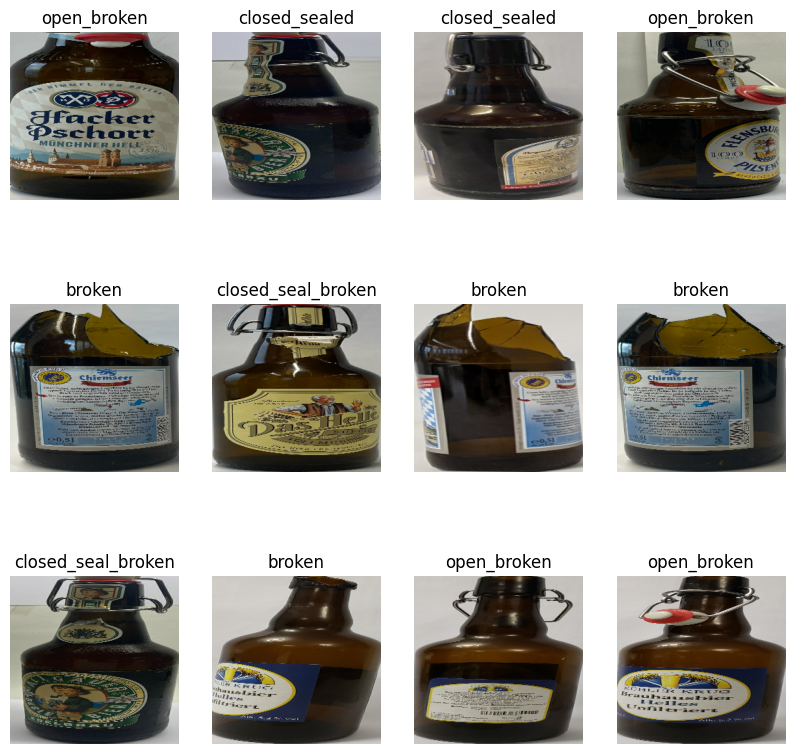

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Construct the CNN model with Keras layers

In [6]:
from tensorflow import keras
from keras import layers
num_classes = len(class_names)

model = keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 260, 260, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 260, 260, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 130, 130, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 130, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 65, 64)        1

Specify callbacks like early stopping and reduce learning rate

In [7]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping = EarlyStopping(
    patience=6
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=3, min_lr=0.00001)

#no early stopping used to streamline the epochs plotting function
callbacks = [reduce_lr]

Compile the constructed model

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Train the model on the training and validation data

In [9]:
epochs=35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/35
33/33 [==============================] - 13s 381ms/step - loss: 1.4462 - accuracy: 0.4558 - val_loss: 0.7425 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 2/35
33/33 [==============================] - 12s 369ms/step - loss: 0.4555 - accuracy: 0.8196 - val_loss: 0.3807 - val_accuracy: 0.7985 - lr: 0.0010
Epoch 3/35
33/33 [==============================] - 12s 368ms/step - loss: 0.2245 - accuracy: 0.9117 - val_loss: 0.2469 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 4/35
33/33 [==============================] - 12s 360ms/step - loss: 0.1243 - accuracy: 0.9573 - val_loss: 0.2217 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 5/35
33/33 [==============================] - 13s 376ms/step - loss: 0.1069 - accuracy: 0.9563 - val_loss: 0.2384 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 6/35
33/33 [==============================] - 12s 360ms/step - loss: 0.0702 - accuracy: 0.9734 - val_loss: 0.1321 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 7/35
33/33 [==============================] - 12s 348ms/st

Save the model and its weights for use without training

In [12]:
model.save('BeerBottleCNN.h5')


Plot the accuracy and loss function of training and validation in two plots

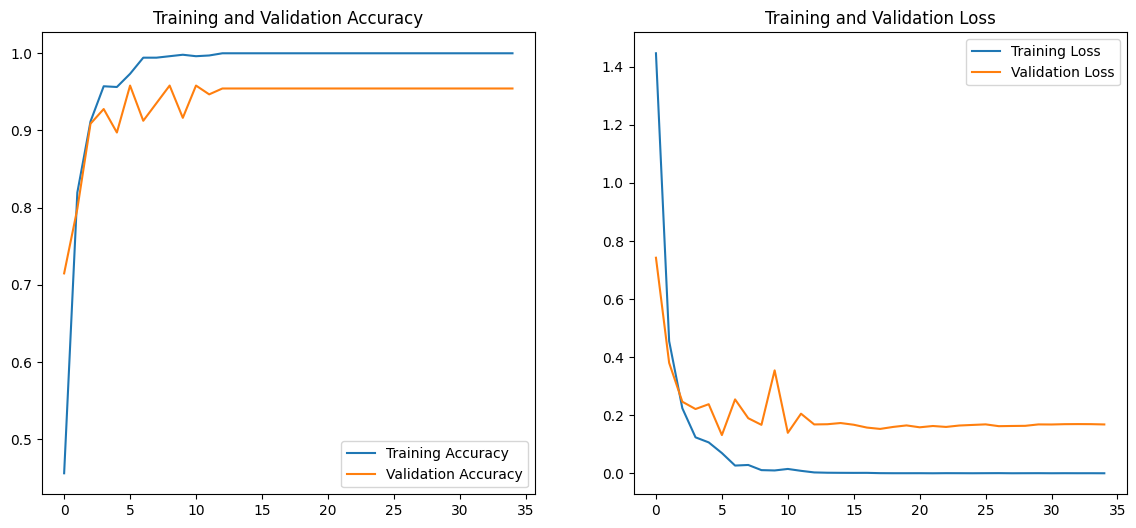

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Possibility to load the model from a file and skip the training

In [16]:
model_loaded = tf.keras.models.load_model('BeerBottleCNN.h5')
model = model_loaded
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 260, 260, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 260, 260, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 130, 130, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 130, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 65, 64)        1

Creating a test dataset from the specified folder

In [18]:
path_test = 'code/test_images_cropped'
test_batchsize = 4

test_ds = tf.keras.utils.image_dataset_from_directory(
  path_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=test_batchsize
)

Found 4 files belonging to 4 classes.


Evaluate the performance with test data

In [19]:
results= model.evaluate(test_ds)
print(f"test loss: {results[0]}: test acc: {results[1]*100}%")


1/1 [==============================] - 0s 44ms/step - loss: 0.3503 - accuracy: 0.7500
test loss: 0.3503337800502777: test acc: 75.0%


Generate predictions (probabilities -- the output of the last layer) on new data using `predict`

1/1 [==============================] - 0s 25ms/step


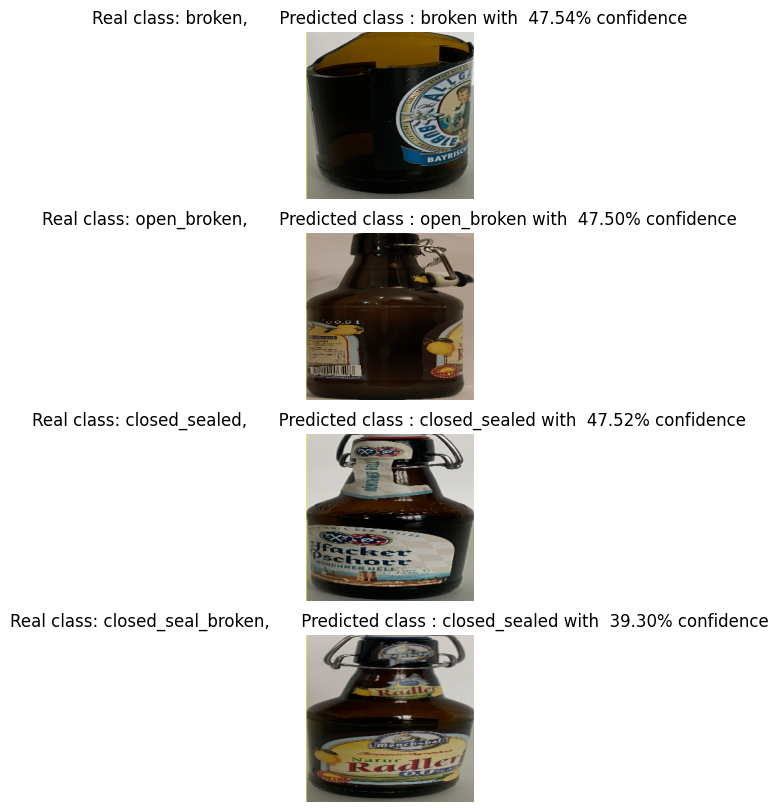

In [34]:
image ,label = next(iter(test_ds))
fig, axes = plt.subplots(len(label),1,figsize=(10,10))
for idx, axe in enumerate(axes.flatten()):
    axe.axis('off')
    pred = model.predict(image[idx][None,...])
    y_pred = np.argmax(pred)
    score = tf.nn.softmax(pred)
    axe.imshow(image[idx].numpy().astype("uint8"))
    axe.set_title(f'Real class: {class_names[label[idx]]},      Predicted class : {class_names[y_pred]} with  {100 * np.max(score):.2f}% confidence')